In [ ]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn
import seaborn as sns

Mounted at /content/drive


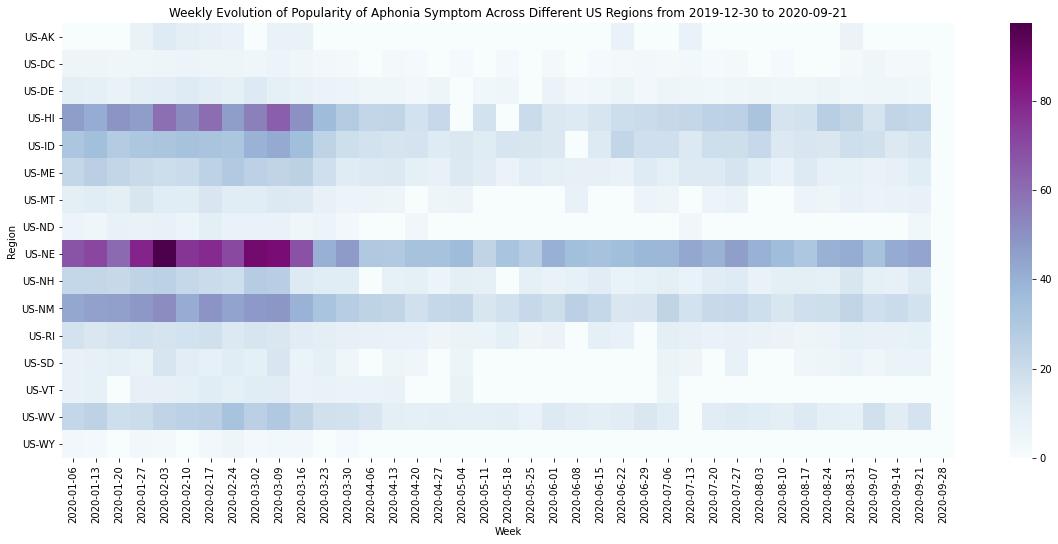

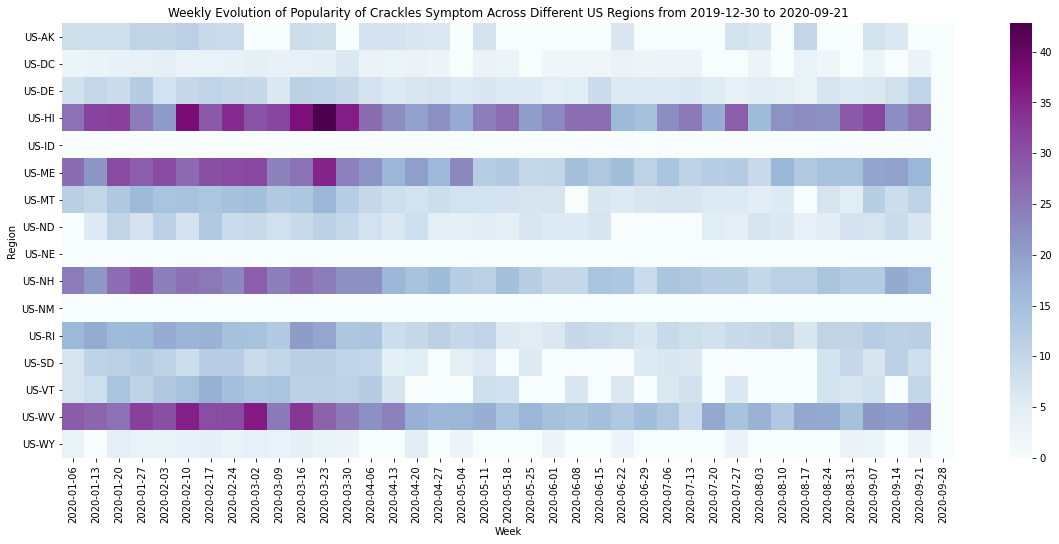

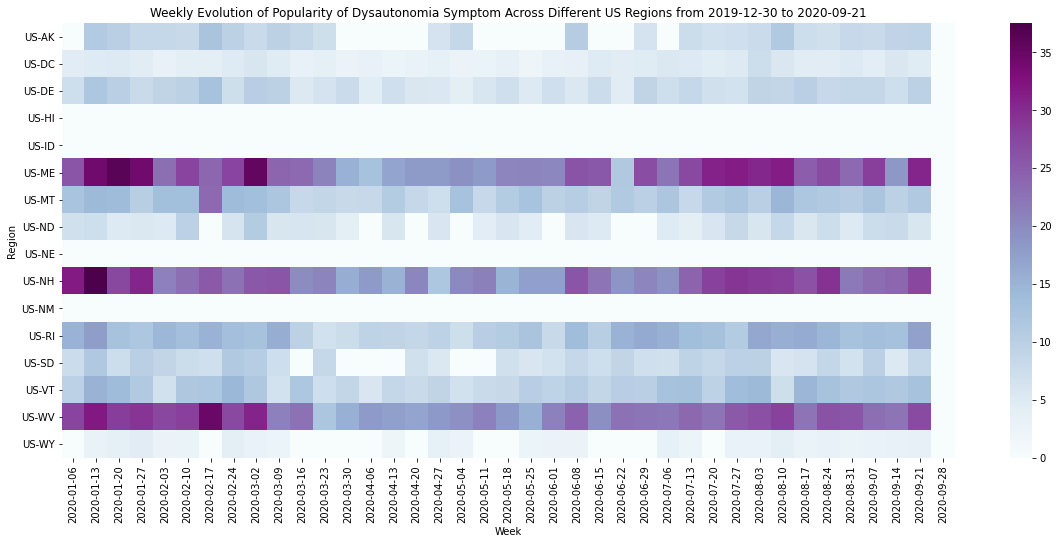

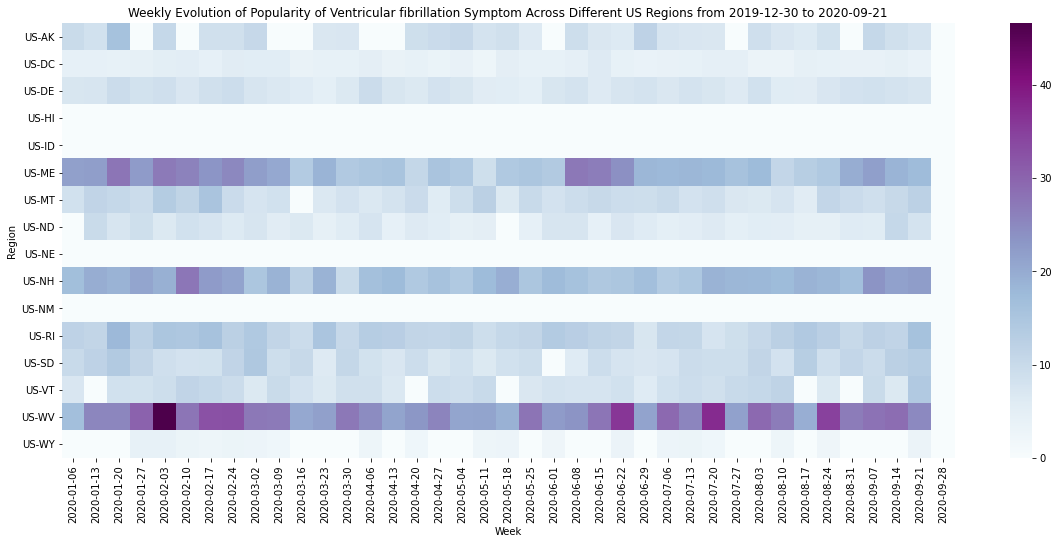

In [ ]:
%matplotlib inline

df = pd.read_csv('./combined.csv', skiprows=0)

df_top_symptoms = df.copy()

df_top_symptoms.drop(df_top_symptoms.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
df_top_symptoms = df_top_symptoms.loc[:, (df_top_symptoms==0).mean() < .331]

top = []
for (columnName, columnData) in df_top_symptoms.iteritems(): 
    top.append(str(columnName))

for i in range(len(top)):
  df_plot_symptom = df.copy()
  df_plot_symptom = df_plot_symptom.pivot('open_covid_region_code', 'date', top[i])
  fig = plt.figure(figsize=(20,8))
  display_heat_map = sns.heatmap(df_plot_symptom, cmap="BuPu")
  display_heat_map.set(xlabel='Week', ylabel='Region')
  display_heat_map.set_title('Weekly Evolution of Popularity of ' + top[i].split("symptom:",1)[1]  + ' Symptom Across Different US Regions from 2019-12-30 to 2020-09-21')

plt.show()

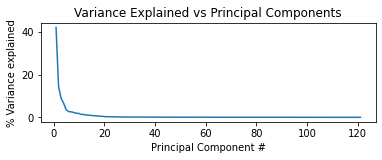

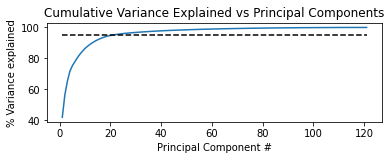

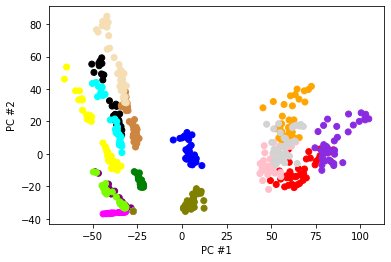

In [ ]:
X = df.copy()

X.drop(X.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
data = np.array(X)

pca = PCA()
pca.fit(data)

num_pc_components = len(pca.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")
plt.show()

plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")
plt.show()


X = df.copy()

target = X.open_covid_region_code
X.drop(X.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
data = np.array(X)

pca = PCA(n_components=3)
pca.fit(data)
data_reduced = pca.transform(X)

colors = {'US-AK':'red', 'US-DC':'green', 'US-DE':'blue', 'US-HI':'yellow', 'US-ID':'purple', 'US-ME':'black', 'US-MT':'orange', 'US-ND':'pink', 'US-NE':'magenta',
 'US-NH':'cyan', 'US-NM':'lawngreen', 'US-RI':'peru', 'US-SD':'lightgray', 'US-VT':'blueviolet', 'US-WV':'wheat', 'US-WY':'olive'}

plt.scatter(data_reduced[:,0], data_reduced[:,1], c=target.map(colors))
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

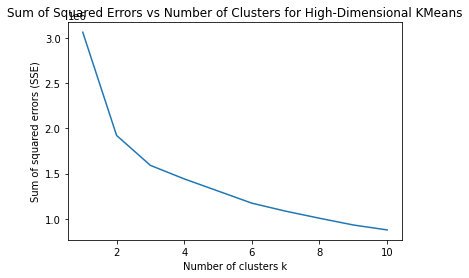

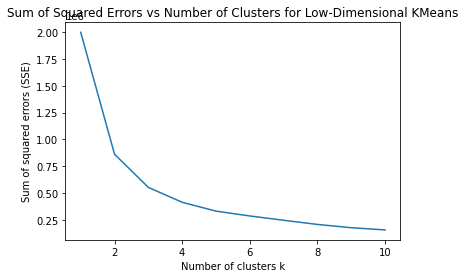

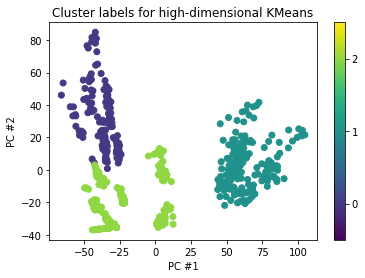

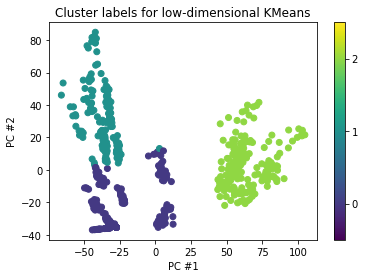

In [ ]:
xs = [1,2,3,4,5,6,7,8,9,10]
ys_high = []
ys_low = []

for k in xs: 
  kmeans_high = KMeans(n_clusters=k, random_state=0)
  kmeans_high.fit(data)

  kmeans_low = KMeans(n_clusters=k, random_state=0)
  kmeans_low.fit(data_reduced)

  ys_high.append(kmeans_high.inertia_)
  ys_low.append(kmeans_low.inertia_)

plt.plot(xs, ys_high)
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared errors (SSE)")
plt.title("Sum of Squared Errors vs Number of Clusters for High-Dimensional KMeans")
plt.show()

plt.plot(xs, ys_low)
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared errors (SSE)")
plt.title("Sum of Squared Errors vs Number of Clusters for Low-Dimensional KMeans")
plt.show()

kmeans_high = KMeans(n_clusters=3, random_state=0)
kmeans_high.fit(data)
y_pred_high = kmeans_high.predict(data)

kmeans_low = KMeans(n_clusters=3, random_state=0)
kmeans_low.fit(data_reduced)
y_pred_low = kmeans_low.predict(data_reduced)

plt.scatter(data_reduced[:,0], data_reduced[:,1], c=y_pred_high)
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for high-dimensional KMeans")
plt.show()

plt.scatter(data_reduced[:,0], data_reduced[:,1], c=y_pred_low)
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for low-dimensional KMeans")
plt.show()